# Creditworthiness Analysis

**Goal**: preprocess data and analyze if different factors (family_status, children and purpose) can influence bank credit users' depts.

## Data and Libraries Import

In [60]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('/datasets/data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


The table contains not only the factors listed in the task, but also other customers' features. *days_employed* column numbers look suspicious, especially the negative numbers.

## Preprocessing

### Working with missing data

Identify missing data

In [62]:
display(df.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Check if missing data for *days_emloyed* and *total_income* are in the same rows

In [63]:
len(df.loc[df['days_employed'].isna() & df['total_income'].isna()])

2174

All missing *days_emloyed* and *total_income* information is absent for the same clients.

Employment tenure isn't key information for the current research, so *days_emloyed* column can be dropped.

Total income, on the contary, can be valuble information for credit scoring, so I will analyse *income_type* and fill the gaps in data based on this data.

In [64]:
df = df.drop('days_employed', 1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   dob_years         21525 non-null  int64  
 2   education         21525 non-null  object 
 3   education_id      21525 non-null  int64  
 4   family_status     21525 non-null  object 
 5   family_status_id  21525 non-null  int64  
 6   gender            21525 non-null  object 
 7   income_type       21525 non-null  object 
 8   debt              21525 non-null  int64  
 9   total_income      19351 non-null  float64
 10  purpose           21525 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


In [65]:
df_gb_income_type = df.groupby('income_type')[['total_income']].apply(lambda x: x.isna().sum())

df_gb_income_type['income_type_total'] = df['income_type'].value_counts() 
df_gb_income_type

,total_income,income_type_total
income_type,,
безработный,0,2
в декрете,0,1
госслужащий,147,1459
компаньон,508,5085
пенсионер,413,3856
предприниматель,1,2
сотрудник,1105,11119
студент,0,1


For public service (госслужащий), companions (компаньон) and employees (сотрудник) credit users part with no income information is around 10%, and the dataset is large enough, so missing information can be filled with median *total_income* for each *income_type*. For retired  customers (пенсионер) this percentage is a bit higher, but on the other hand, income scattering might be quite narrow for this group, so this kind of filling missing values can be relevant here, too. Check this assumption and fill the missing data.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


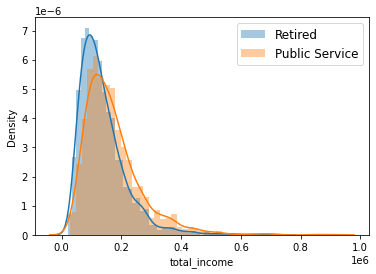

In [66]:
df_to_plot = df[df['income_type'] == 'пенсионер']
df_to_plot = df_to_plot.dropna(subset=['total_income'])
sb.distplot(df_to_plot['total_income'], label='Retired') 

df_to_plot = df[df['income_type'] == 'госслужащий']
df_to_plot = df_to_plot.dropna(subset=['total_income'])
sb.distplot(df_to_plot['total_income'], label='Public Service')
plt.legend(prop={'size': 12});


In [67]:
governmental = df[df['income_type'] == 'госслужащий']['total_income'].median() # median income for public service 
retired = df[df['income_type'] == 'пенсионер']['total_income'].median() # median income for retired
empoyed = df[df['income_type'] == 'сотрудник']['total_income'].median() # median income for employees
companion = df[df['income_type'] == 'компаньон']['total_income'].median() # median income for companions

median_replace = {'госслужащий':governmental, 'пенсионер':retired, 'сотрудник':empoyed, 'компаньон':companion}

#Fill the gaps
for inc_type, tot_income in median_replace.items():
    
    df.loc[(df['income_type'] == inc_type) & (df['total_income'].isnull()),'total_income'] = tot_income

In [68]:
df.isna().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        1
purpose             0
dtype: int64

The only income type for which no replacement was done is enterpreneur (предпринематель). There are only two of a kind in the dataset, so no median fill scheme can be applied. Check if it's a duplicate:

In [69]:
df[df['income_type'] == 'предприниматель']

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5936,0,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости
18697,0,27,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы


These are clearly two different enterpreneurs. It's worth checking with the bank why there are only two of them among 21+ thousands and what's the big difference between this type and companions. For now we just drop the one with missing income data.

In [70]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.isna().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21524 non-null  int64  
 1   dob_years         21524 non-null  int64  
 2   education         21524 non-null  object 
 3   education_id      21524 non-null  int64  
 4   family_status     21524 non-null  object 
 5   family_status_id  21524 non-null  int64  
 6   gender            21524 non-null  object 
 7   income_type       21524 non-null  object 
 8   debt              21524 non-null  int64  
 9   total_income      21524 non-null  float64
 10  purpose           21524 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


### Duplicates processing

Check table for explicit duplicates

In [72]:
f'{df.duplicated().sum()} explicit duplicates determined in the table'

'54 explicit duplicates determined in the table'

Drop explicit duplicates

In [73]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df.info()
f'{df.duplicated().sum()} explicit duplicates determined in the table'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21470 entries, 0 to 21469
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21470 non-null  int64  
 1   dob_years         21470 non-null  int64  
 2   education         21470 non-null  object 
 3   education_id      21470 non-null  int64  
 4   family_status     21470 non-null  object 
 5   family_status_id  21470 non-null  int64  
 6   gender            21470 non-null  object 
 7   income_type       21470 non-null  object 
 8   debt              21470 non-null  int64  
 9   total_income      21470 non-null  float64
 10  purpose           21470 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


'0 explicit duplicates determined in the table'

To check for implicit duplicates it's necessary to have a look at unique values in categorial columns.

In [74]:
for col in ['children', 'education', 'family_status', 'gender']:
    display(col, df[col].unique())

'children'

array([ 1,  0,  3,  2, -1,  4, 20,  5])

'education'

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

'family_status'

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

'gender'

array(['F', 'M', 'XNA'], dtype=object)

Looks like not all clients have provided gender information, but everything else is OK with *gender* and *family_status* columns. Meanwhile in *education* column same education level can be written in different cases. Bring all education data to lowercase

In [75]:
df['education'] = df['education'].str.lower()
display('education',df['education'].unique())

'education'

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

*children* column shoul contain number of children, but several numbers look strange

In [76]:
df['children'].value_counts()

 0     14106
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

The dataset has 47 rows with negative number of children (-1), and 76 customers with 20 (!) kids. It's worth cheking with the bank if it is due to misprints (e.g. -1 means 1 child, and 20 means 2), or downloading mistakes, or these numbes are carrying categorial meanings (e.g. -1 - expecting a child, and 20 means 5+ children). While awaiting for responce, these rows would not be used in further analysis.

### Lemmatization

To classify purposes of credits it is important to identify key words and categorize data based on them. See what purposes exist in the dataframe

In [77]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Lemmatize *purpose* column

In [78]:
from pymystem3 import Mystem
m = Mystem() 
df_lemm = []
for line in range(0,df.shape[0]):
    df_lemm.append(m.lemmatize(df.loc[line,'purpose']))
df['purpose_lemm'] = df_lemm

from collections import Counter
df_lemm_join = []
for i in range(len(df_lemm)):
    df_lemm_join += df_lemm[i]
display(Counter(df_lemm_join)) 

Counter({'покупка': 5899,
         ' ': 33594,
         'жилье': 4461,
         '\n': 21470,
         'приобретение': 461,
         'автомобиль': 4308,
         'дополнительный': 907,
         'образование': 4014,
         'сыграть': 769,
         'свадьба': 2335,
         'операция': 2604,
         'с': 2918,
         'на': 2228,
         'проведение': 773,
         'для': 1290,
         'семья': 638,
         'недвижимость': 6352,
         'коммерческий': 1312,
         'жилой': 1230,
         'строительство': 1879,
         'собственный': 635,
         'подержать': 478,
         'свой': 2231,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'подержанный': 486,
         'получение': 1315,
         'высокий': 1374,
         'профильный': 436,
         'сдача': 652,
         'ремонт': 607})

According to lemmatization results there are 4 main purposes: real estate (жилье/недвижимость), vehicle (автомобиль), wedding (свадьба) and education (образование).

### Data Categorization

#### Credit Purposes

Теперь зададим категории для целей получения кредитов.

In [79]:
#Categorization dictionary
purpose_lemm_dict = {
    'purpose_lemm':['Real estate', 'Vehicle', 'Wedding', 'Education'], 
                     'purpose_id':[0, 1, 2, 3]
}
df_purpose_lemm_dict = pd.DataFrame(purpose_lemm_dict)
display(df_purpose_lemm_dict)


def purpose_category(row):
    """
    Returns purpose_id according to purpose_lemm_dict
    """
    
    purpose_lemma = row['purpose_lemm']
    if 'жилье' in purpose_lemma or 'недвижимость' in purpose_lemma:
        return 0
    elif 'автомобиль' in purpose_lemma:
        return 1
    elif 'свадьба' in purpose_lemma:
        return 2
    elif 'образование' in purpose_lemma:
        return 3

def purpose_category_text(row):
    """
    Returns purpose key words (purpose_lemm) according to purpose_lemm_dict
    """
    
    purpose_lemma = row['purpose_lemm']
    if 'жилье' in purpose_lemma or 'недвижимость' in purpose_lemma:
        return 'Real estate'
    elif 'автомобиль' in purpose_lemma:
        return 'Vehicle'
    elif 'свадьба' in purpose_lemma:
        return 'Wedding'
    elif 'образование' in purpose_lemma:
        return 'Education'
    
df['purpose_id']  = df.apply(purpose_category, axis=1)
df['purpose_short'] = df.apply(purpose_category_text, axis=1)
df.head()
    

,purpose_lemm,purpose_id
0,Real estate,0
1,Vehicle,1
2,Wedding,2
3,Education,3


,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemm,purpose_id,purpose_short
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,"[покупка, , жилье, \n]",0,Real estate
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,"[приобретение, , автомобиль, \n]",1,Vehicle
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,"[покупка, , жилье, \n]",0,Real estate
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,"[дополнительный, , образование, \n]",3,Education
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,"[сыграть, , свадьба, \n]",2,Wedding


#### Number of Children
Having children is one of the key factors that should be analysed for the task, so it's worth making two kinds of categories: one would be short (0 - no children, 1 - has children) и and the other more detailed (0 - no children, 1 - 1-2 kids, 2 - large family with 3+ children).

In [80]:
children_dict_short = {
    'have_children':['no children', 'has children'], 
                     'have_children_id':[0, 1]
}
df_children_dict_short = pd.DataFrame(children_dict_short)
display(df_children_dict_short)

,have_children,have_children_id
0,no children,0
1,has children,1


In [81]:
children_dict_long = {
    'family_size':['no children', '1-2 children', '3+ children'], 
                     'family_size_id':[0, 1, 2]
}
df_children_dict_long = pd.DataFrame(children_dict_long)
display(df_children_dict_long)

,family_size,family_size_id
0,no children,0
1,1-2 children,1
2,3+ children,2


Functions for categorisation

In [82]:
def have_children_id(row):
    """
    Returns have_children according to df_children_dict_short
    """
    if row['children'] == 0:
        return 'no children'
    elif 0 < row['children'] < 6:
        return 'has children'

def family_size_id(row):
    """
    Returns family_size_id according to df_children_dict_short
    """
    if row['children'] == 0:
        return 'no children'
    elif 0 < row['children'] < 3:
        return '1-2 children'
    elif 2 < row['children'] < 6:
        return '3+ children'
    

df['have_children_id'] = df.apply(have_children_id, axis=1)
df['family_size_id'] = df.apply(family_size_id, axis=1)

df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemm,purpose_id,purpose_short,have_children_id,family_size_id
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,"[покупка, , жилье, \n]",0,Real estate,has children,1-2 children
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,"[приобретение, , автомобиль, \n]",1,Vehicle,has children,1-2 children
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,"[покупка, , жилье, \n]",0,Real estate,no children,no children
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,"[дополнительный, , образование, \n]",3,Education,has children,3+ children
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,"[сыграть, , свадьба, \n]",2,Wedding,no children,no children


#### Total Income

Income classes to be used in the research:
   
    Beggary – income below 1 minimum level of subsistence (MLS)
    Poverty - income between 1 to 3 MLS
    Above Poverty - income between 3 to 7 MLS
    Middle class – income between 7 to 11 MLS
    Wealth – income above 11 MLS
    Ultra-wealth - yearly income exceeding 5 mln rub before tax 
                   
Information on customers' location was not included into the dataframe, so it is decided to take Moscow minimum level of subsistence being 18029 in 2021.

In [83]:
income_level_dict = {
    'income_level':['Beggary', 'Poverty','Above Poverty', 'Middle class', 'Wealth', 'Ultra-wealth'], 
                     'income_level_id':[0, 1, 2, 3, 4, 5]
}
df_income_level_dict = pd.DataFrame(income_level_dict)
display(df_income_level_dict)

,income_level,income_level_id
0,Beggary,0
1,Poverty,1
2,Above Poverty,2
3,Middle class,3
4,Wealth,4
5,Ultra-wealth,5


In [84]:
def income_level_text(row):
    """
    Returns income level in accordance with df_income_level_dict:
    """
    living_wage = 18029
    tot_income = row['total_income']
    if tot_income < living_wage:
        return 'Beggary'
    elif tot_income < 3*living_wage:
        return 'Poverty'
    elif tot_income < 7*living_wage:
        return 'Above Poverty'
    elif tot_income < 11*living_wage:
        return 'Middle class'
    elif tot_income < 5000000*0.87/12: #Среднемесячный доход после вычета НДФЛ 13%
        return 'Wealth'
    else:
        return 'Ultra-wealth'
    
df['income_level'] = df.apply(income_level_text, axis=1)
df.head() 

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemm,purpose_id,purpose_short,have_children_id,family_size_id,income_level
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,"[покупка, , жилье, \n]",0,Real estate,has children,1-2 children,Wealth
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,"[приобретение, , автомобиль, \n]",1,Vehicle,has children,1-2 children,Above Poverty
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,"[покупка, , жилье, \n]",0,Real estate,no children,no children,Middle class
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,"[дополнительный, , образование, \n]",3,Education,has children,3+ children,Wealth
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,"[сыграть, , свадьба, \n]",2,Wedding,no children,no children,Middle class


In [85]:
df['income_level'].value_counts()

Middle class     8405
Above Poverty    7359
Wealth           4402
Ultra-wealth      774
Poverty           530
Name: income_level, dtype: int64

Looks like this bank does not give credits to people with income below 1 MSL.

#### Drop unneeded coloumns


In [86]:
df_short = df.drop(['purpose_lemm', 'purpose'], 1)
df_short.head(15)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose_id,purpose_short,have_children_id,family_size_id,income_level
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,0,Real estate,has children,1-2 children,Wealth
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,1,Vehicle,has children,1-2 children,Above Poverty
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,0,Real estate,no children,no children,Middle class
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,3,Education,has children,3+ children,Wealth
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,2,Wedding,no children,no children,Middle class
5,0,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,0,Real estate,no children,no children,Wealth
6,0,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,0,Real estate,no children,no children,Wealth
7,0,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,3,Education,no children,no children,Middle class
8,2,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,2,Wedding,has children,1-2 children,Above Poverty
9,0,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,0,Real estate,no children,no children,Middle class


## Analysis and results

- **Does having credit dept depend on having children?**

Calculate percent of deptors in two categories - with and without kids

In [87]:
df_have_children_pivot = df_short.pivot_table(index=['have_children_id'], values='debt', aggfunc=['sum', 'count'])
df_have_children_pivot['debt_percent'] = df_have_children_pivot['sum'] / df_have_children_pivot['count']
df_have_children_pivot['debt_percent'] = df_have_children_pivot['debt_percent'].map('{:,.1%}'.format)
df_have_children_pivot

,sum,count,debt_percent
,debt,debt,
have_children_id,,,
has children,669,7241,9.2%
no children,1063,14106,7.5%


The difference between percent of deptors in two categories is around 1.7%, people with children have credit debts more often.

Analyze narrower categories

In [88]:
df_family_size_pivot = df_short.pivot_table(index=['family_size_id'], values='debt', aggfunc=['sum', 'count'])
df_family_size_pivot['debt_percent'] = df_family_size_pivot['sum'] / df_family_size_pivot['count']
df_family_size_pivot['debt_percent'] = df_family_size_pivot['debt_percent'].map('{:,.1%}'.format)
df_family_size_pivot

,sum,count,debt_percent
,debt,debt,
family_size_id,,,
1-2 children,638,6861,9.3%
3+ children,31,380,8.2%
no children,1063,14106,7.5%


**Result**

In general percentage of debtors among people without children is 1.7% lower, than among clients with children. It is worth mentioning though, that people with 3+ children are more diligent in paying their credits than customers with 1-2 kids. 

- **Does having credit dept depend on family status?**

Calculate percent of deptors in family status categories 

In [89]:
df_family_status_pivot = df_short.pivot_table(index=['family_status'], values='debt', aggfunc=['sum', 'count'])
df_family_status_pivot['debt_percent'] = df_family_status_pivot['sum'] / df_family_status_pivot['count']
df_family_status_pivot['debt_percent'] = df_family_status_pivot['debt_percent'].map('{:,.1%}'.format)
df_family_status_pivot

,sum,count,debt_percent
,debt,debt,
family_status,,,
Не женат / не замужем,274,2810,9.8%
в разводе,85,1195,7.1%
вдовец / вдова,63,959,6.6%
гражданский брак,388,4163,9.3%
женат / замужем,931,12343,7.5%


Highest percentage of debtors is within unmarried (Не женат / не замужем) customers and clients in civil partnership (гражданский брак) - above 9%. Married (женат / замужем) and divorced (в разводе) customers also have close percentage of detors - above 7%. Widowed people have lowes share of people with credit debts - 6.6%.

Analyzing famiy status together with gender

In [90]:
df_family_status_pivot = df_short.pivot_table(index=['family_status', 'gender'], values='debt', aggfunc=['sum', 'count'])
df_family_status_pivot['debt_percent'] = df_family_status_pivot['sum'] / df_family_status_pivot['count']
df_family_status_pivot['debt_percent'] = df_family_status_pivot['debt_percent'].map('{:,.1%}'.format)
df_family_status_pivot

sum count debt_percent
                             debt  debt             
family_status         gender                        
Не женат / не замужем F       118  1729         6.8%
                      M       156  1081        14.4%
в разводе             F        61   936         6.5%
                      M        24   259         9.3%
вдовец / вдова        F        52   904         5.8%
                      M        11    55        20.0%
гражданский брак      F       233  2856         8.2%
                      M       155  1306        11.9%
                      XNA       0     1         0.0%
женат / замужем       F       530  7764         6.8%
                      M       401  4579         8.8%

Widowed men subset is too small, although is shows extreme 20% debtors percentage, this information shoul not be taken for conclusions. 

**Result**

Although there are more women in all categories, percentage of debtors among them is lower, than for men in all family statuses. Unmarried men seem to be least diligent in paying their credits in time (14.4%). Among women the highest share of debtors is for divorced clients (8.8%).

- **Does having credit dept depend on income level?**

Calculate percent of deptors in income level categories 

In [91]:
df_income_level_id_pivot = df_short.pivot_table(index=['income_level'], values='debt', aggfunc=['sum', 'count'])
df_income_level_id_pivot['debt_percent'] = df_income_level_id_pivot['sum'] / df_income_level_id_pivot['count']
df_income_level_id_pivot['debt_percent'] = df_income_level_id_pivot['debt_percent'].map('{:,.1%}'.format)
#Combining with dictionary
df_income_level_id_pivot_fin = df_income_level_id_pivot.merge(df_income_level_dict, on='income_level', how='left')

# Change column names to nice ones
columns_nice = {'income_level':'income_level', ('sum', 'debt'):'total_debtors', 
                ('count', 'debt'):'total_loans', ('debt_percent', ''):'debt_percent', 
               'income_level_id':'income_level_id'}
df_income_level_id_pivot_fin = df_income_level_id_pivot_fin.rename(columns=columns_nice)

#Pivot table sorting
df_income_level_id_pivot_fin.sort_values(by='income_level_id')



/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,income_level,total_debtors,total_loans,debt_percent,income_level_id
2,Poverty,34,530,6.4%,1
0,Above Poverty,622,7359,8.5%,2
1,Middle class,720,8405,8.6%,3
4,Wealth,317,4402,7.2%,4
3,Ultra-wealth,48,774,6.2%,5


**Result**

Almost equally low percentage of debtors can be observed for poor and ultra-wealthy people (6.4% and 6.2% respectively). Medium income categories (above poverty and middle class) show lowest statistics - 8.5% and 8.6%.

- **Does having credit dept depend on the purpose of this credit?**

In [92]:
df_purpose_short_pivot = df_short.pivot_table(index=['purpose_short'], values='debt', aggfunc=['sum', 'count'])
df_purpose_short_pivot['debt_percent'] = df_purpose_short_pivot['sum'] / df_purpose_short_pivot['count']
df_purpose_short_pivot['debt_percent'] = df_purpose_short_pivot['debt_percent'].map('{:,.1%}'.format)
df_purpose_short_pivot

,sum,count,debt_percent
,debt,debt,
purpose_short,,,
Education,370,4014,9.2%
Real estate,782,10813,7.2%
Vehicle,403,4308,9.4%
Wedding,186,2335,8.0%


**Result**

The highest percentage of debtors is among those who took a loan for a vehicle or education, 9.4% and 9.2%, respectively. More than 1% less share of debtors is within customers who took credit to pay for their wedding. The largest group is clients who need a loan for house purchase or renovation and other real estate transactions, being at the same time the most responsible - only 7.2% of debtors.

## Conclusion

1. Not all data were suitable for analysis, and some rows and columns had to be excluded. It is necessary to clarify where the errors come from in order to correct them and expand the subsets.
2. The influence of various factors on credit debts was analysed:
- Credit debt is affected not only by the presence of children, but also by their number, and families with many children turned out to be somewhat more disciplined than people with 1-2 children. Least of all debts on loans from childless borrowers.
- Marital status affects male borrowers more than women. Among women, the most diligent category of payers are widows, and the largest percentage of debtors is among those who live in a civil partnership. For single, married and divorced women, the percentage of debtors is almost the same. Among men, unmarried and, possibly, widowers are the least responsible for paying off loans, and married people are the most disciplined category of male borrowers. 
- The categories of borrowers with the highest and lowest incomes are the least likely to have loan debts, and most often the debtors are representatives of the category of low ("above poverty") and middle income.
- According to the purpose of the loan, the smallest percentage of debtors is among those who took a loan for real estate transactions, and the largest - for a car and education.
3. The conclusions made in this analysis can be used further for credit scoring calculation. Also, a possible way forward for the work may be to consider the influence of other combinations of factors, especially after the revision of the dataset.